In [1]:
import numpy as np
import time
import os
import sys
import scipy
import math
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
import pandas as pd
import psutil
import json
from tqdm import tqdm
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import bigbadbrain as bbb
from scipy.linalg import toeplitz
import scipy.linalg as sl
from scipy.signal import convolve2d
from scipy.signal import convolve
import sklearn
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn import linear_model

#from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import cv2
import os
import statsmodels.api as sm

from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
from IPython.display import HTML

%matplotlib inline

In [2]:
directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_19/func_0'

# Load fictrac and timestamps

In [3]:
timestamps = bbb.load_timestamps(os.path.join(directory, 'imaging'))
fictrac = bbb.load_fictrac(os.path.join(directory, 'fictrac'))


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 4.82 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.40 sec


# Load fictrac video

In [4]:
cap = cv2.VideoCapture('/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/imports/fictrac/fictrac-20190218_133014-raw.avi')
i=0
frames = []
ret = True
while ret is True and i<80000:
    i+=1
    if i%1000 == 0:
        print(i)
    # Capture frame-by-frame
    ret, frame = cap.read()
    frames.append(frame)
cap.release()

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000


# Load tSNE

In [5]:
file = os.path.join(directory, 'tsne', '20191114-165446.npy')
with open(file) as json_file:
    tsne = json.load(json_file)
tsne_x = [pair[0] for pair in tsne]
tsne_y = [pair[1] for pair in tsne]
X=np.vstack((tsne_x,tsne_y)).T

In [16]:
X.shape

(4554, 2)

In [6]:
import hdbscan
from random import randint
colors = []

for i in range(100):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

In [7]:
min_cluster_size=10
min_samples=10
cluster_selection_epsilon=1.8

t0 = time.time()
HDBSCAN = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                    min_samples=min_samples,
                                    cluster_selection_epsilon=cluster_selection_epsilon,
                                    cluster_selection_method='leaf').fit(X)
HDBSCAN.labels_ += 1
print('Duration: {:0.0f}s'.format(time.time()-t0))

Duration: 0s


In [141]:
clusters = {}
for i in range(max(HDBSCAN.labels_)):
    indicies = np.where(HDBSCAN.labels_ == i)[0]
    clusters[i] = X[indicies,:]

In [142]:
cluster_means = {}
for i in range(max(HDBSCAN.labels_)):
    np.mean(clusters[i],axis=0)
    cluster_means[i] = np.mean(clusters[i],axis=0)

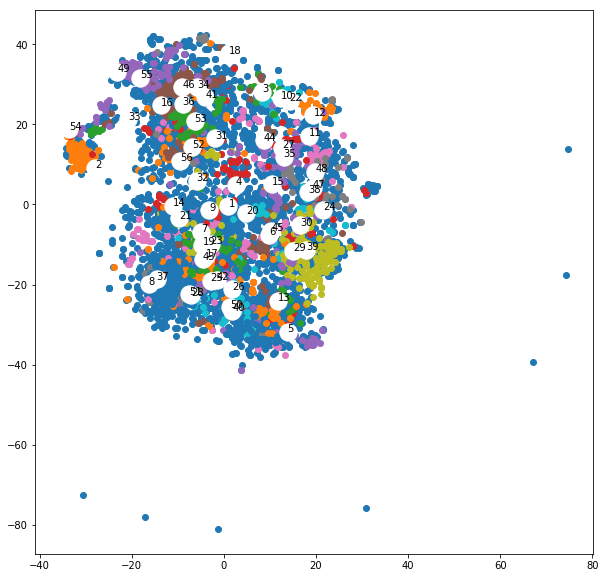

In [143]:
plt.figure(figsize=(10,10))
ax = plt.subplot()
for i in clusters:
    plt.plot(clusters[i][:,0],clusters[i][:,1],linestyle='',marker='o',zorder=0)
    plt.scatter(cluster_means[i][0],cluster_means[i][1],color='white',s=300,zorder=1)
    plt.text(cluster_means[i][0],cluster_means[i][1],str(i+1))

In [11]:
clusters[1]

array([[27.88617325, 13.27077484],
       [27.82802773, 13.16764832],
       [26.5267601 , 15.22999096],
       [26.66354752, 15.12902546],
       [28.04388809, 14.40553284],
       [28.22681618, 13.15341473],
       [27.72981644, 14.33348656],
       [29.89110947, 15.79171944],
       [32.69868469,  9.9624548 ],
       [32.79397583,  2.67079258],
       [30.65164948,  8.48463631],
       [34.16235733,  7.29409361],
       [29.8991394 , 15.89819527],
       [31.99461555,  1.78973222],
       [34.00819778,  2.13046145],
       [33.56594467,  1.95844734],
       [33.62238312,  1.22870529],
       [32.75442123,  1.57936239],
       [30.76445389, 15.14572239],
       [34.69189453,  8.19311905],
       [30.6252346 ,  4.6822319 ],
       [33.66851044,  2.4611814 ],
       [32.09144211,  2.49921966],
       [32.26507187,  2.35854816],
       [34.65757751, 13.01803017],
       [32.11834717,  4.75340366],
       [34.66537476, 12.37723255],
       [33.76409912,  2.24742007],
       [31.70009232,

In [13]:
indicies = np.where(HDBSCAN.labels_ == 1)[0]

In [14]:
indicies

array([1869, 2046, 2202, 2212, 2235, 2266, 2461, 2908, 2961, 2980, 3086,
       3237, 3249, 3254, 3280, 3318, 3360, 3372, 3473, 3483, 3489, 3516,
       3518, 3520, 3550, 3557, 3561, 3564, 3584, 3586, 3599, 3619, 3626,
       3655, 3671, 3672, 3682, 3683, 3699, 3718, 3734, 3745, 3757, 3760,
       3761, 3762, 3763, 3766, 3771, 3777, 3778, 3779, 3785, 3787, 3791,
       3792, 3796, 3803, 3809, 3811, 3812, 3817, 3825, 3833, 3837, 3838,
       3839, 3841, 3845, 3851, 3852, 3877, 3882, 3900, 3902, 3912, 3988,
       3991, 4049, 4097, 4099, 4148, 4191, 4307, 4311, 4324, 4351, 4359,
       4388, 4400, 4401, 4449, 4461, 4483, 4495, 4531])

# Actually lets use this new tsne and clustering:

In [17]:
file = os.path.join(directory,'tsne','20191220_100pc_100perplex_clustered.json')
with open(file) as json_file:
    clusters = json.load(json_file)

In [54]:
file = os.path.join(directory,'tsne','20191220_100pc_100perplex.npy')
X = np.load(file)

In [220]:
file = os.path.join(directory,'tsne','clusters.npy')
cluster_vector = np.load(file)

In [221]:
max(cluster_vector)

27

In [45]:
clusters_array = {}
for i in clusters:
    clusters_array[int(i)] = np.asarray(clusters[i])

In [157]:
cluster_means = {}
for i in range(max(clusters_array)+1):
    np.mean(clusters_array[i],axis=0)
    cluster_means[i] = np.mean(clusters_array[i],axis=0)

In [153]:
np.mean(clusters_array[10],axis=0)

array([11.96950684, 20.93496399])

In [150]:
max(clusters_array)

17

(-50, 50)

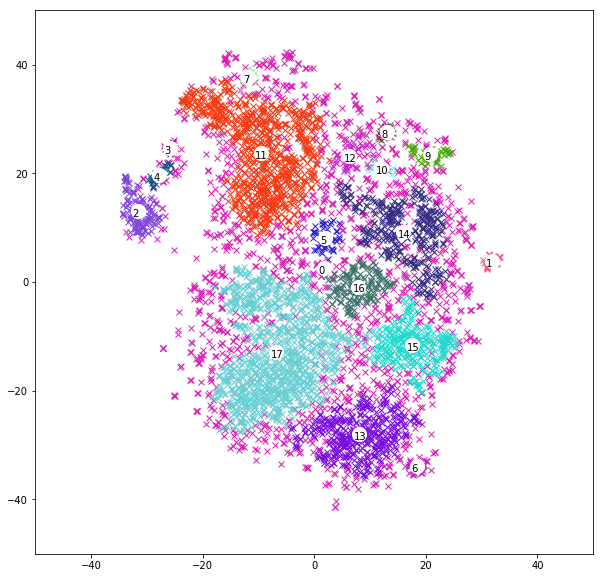

In [214]:
plt.figure(figsize=(10,10))
for i in clusters_array:
    plt.plot(clusters_array[i][:,0],clusters_array[i][:,1],linestyle='',marker='x',color=colors[i],zorder=0)
    plt.scatter(cluster_means[i][0],cluster_means[i][1],color='white',s=200,zorder=1)
    plt.text(cluster_means[i][0]-1,cluster_means[i][1]-1,str(i))
plt.xlim(-50,50)
plt.ylim(-50,50)

In [57]:
#the following code takes a list such as
#[1,1,2,6,8,5,5,7,8,8,1,1,4,5,5,0,0,0,1,1,4,4,5,1,3,3,4,5,4,1,1]
#with states labeled as successive integers starting with 0
#and returns a transition matrix, M,
#where M[i][j] is the probability of transitioning from i to j

def transition_matrix(transitions):
    n = 1+ max(transitions) #number of states

    M = [[0]*n for _ in range(n)]

    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1

    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return M

#test:

t = [1,1,2,6,8,5,5,7,8,8,1,1,4,5,5,0,0,0,1,1,4,4,5,1,3,3,4,5,4,1,1]
m = transition_matrix(cluster_vector)
#for row in m: print(' '.join('{0:.2f}'.format(x) for x in row))

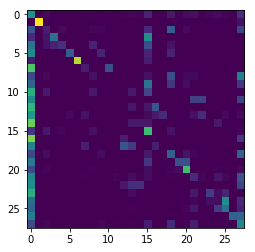

In [59]:
plt.imshow(m)

In [50]:
clusters_array[0][:,1]

array([ 24.45316696,  12.10150242,  12.12005043, ..., -25.0034008 ,
        31.07122421,  19.83533478])

In [43]:
np.asarray(clusters['0'])[:,0]

array([-23.91969299,  24.04174614,  23.96738243, ...,  -0.59073812,
         2.18588018, -24.48984146])

# Align behavior video clips to clusters

In [60]:
def interp_fictrac(fictrac, behavior, fps, resolution, expt_len, timestamps, interp_to):
    camera_rate = 1/fps * 1000 # camera frame rate in ms
    sphere_radius = 4.5e-3
    filter_window = 51
    
    x_original = np.arange(0,expt_len,camera_rate)
    
    if behavior == 'all':
        dx = np.asarray(fictrac['dRotLabX'])
        dy = np.asarray(fictrac['dRotLabY'])
        dz = np.asarray(fictrac['dRotLabZ'])
        dx = scipy.signal.savgol_filter(dx,filter_window,3) * sphere_radius * 50 * 100 * 10
        dy = scipy.signal.savgol_filter(dy,filter_window,3) * sphere_radius * 50 * 100 * 10
        dz = scipy.signal.savgol_filter(dz,filter_window,3) * 180 / np.pi * 50
        fictrac_smoothed = np.sqrt(dx*dx + dy*dy + dz*dz)
    elif behavior == 'Y':
        dy = np.asarray(fictrac['dRotLabY'])
        fictrac_smoothed = scipy.signal.savgol_filter(dy,filter_window,3) * sphere_radius * 50 * 100 * 10
    elif behavior == 'Z':
        dz = np.asarray(fictrac['dRotLabZ'])
        fictrac_smoothed = scipy.signal.savgol_filter(dz,filter_window,3) * 180 / np.pi * 50
    else:
        print('invalid behavior')
    
    #fictrac_smoothed = np.abs(fictrac_smoothed)
    fictrac_interp_temp = interp1d(x_original, fictrac_smoothed, bounds_error = False)
    xnew = np.arange(0,expt_len,resolution) #0 to last time at subsample res
    
    if interp_to is 'timestamps':
        fictrac_interp = fictrac_interp_temp(timestamps[:,25])
    elif interp_to is 'xnew':
        fictrac_interp = fictrac_interp_temp(xnew)
    else:
        print('Invalid interp_to ({})'.format(interp_to))

    # Replace Nans with zeros (for later code)
    np.nan_to_num(fictrac_interp, copy=False);
    
    return fictrac_interp

In [61]:
resolution = 20 #desired resolution in ms
expt_len = 1000*30*60
fps = 50 #of fictrac camera
xnew = np.arange(0,expt_len,resolution)

fictracs_high_res = {}
for behavior in ['all', 'Y', 'Z']:
    fictracs_high_res[behavior] = interp_fictrac(fictrac, behavior, fps, resolution, expt_len, timestamps, 'xnew')

fictracs = {}
for behavior in ['all', 'Y', 'Z']:
    fictracs[behavior] = interp_fictrac(fictrac, behavior, fps, resolution, expt_len, timestamps, 'timestamps')

In [119]:
import ffmpeg

ModuleNotFoundError: No module named 'ffmpeg'

Traceback (most recent call last):
  File "/home/users/brezovec/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/home/users/brezovec/.local/lib/python3.6/site-packages/matplotlib/animation.py", line 999, in _start
    self._init_draw()
  File "/home/users/brezovec/.local/lib/python3.6/site-packages/matplotlib/animation.py", line 1740, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/home/users/brezovec/.local/lib/python3.6/site-packages/matplotlib/animation.py", line 1762, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
  File "<ipython-input-118-8953fccfde98>", line 28, in animate
    axes[k].set_array(frames[behavior_idx][35:210,325:500,:])
AttributeError: 'Axes' object has no attribute 'set_array'


RuntimeError: Requested MovieWriter (ffmpeg) not available

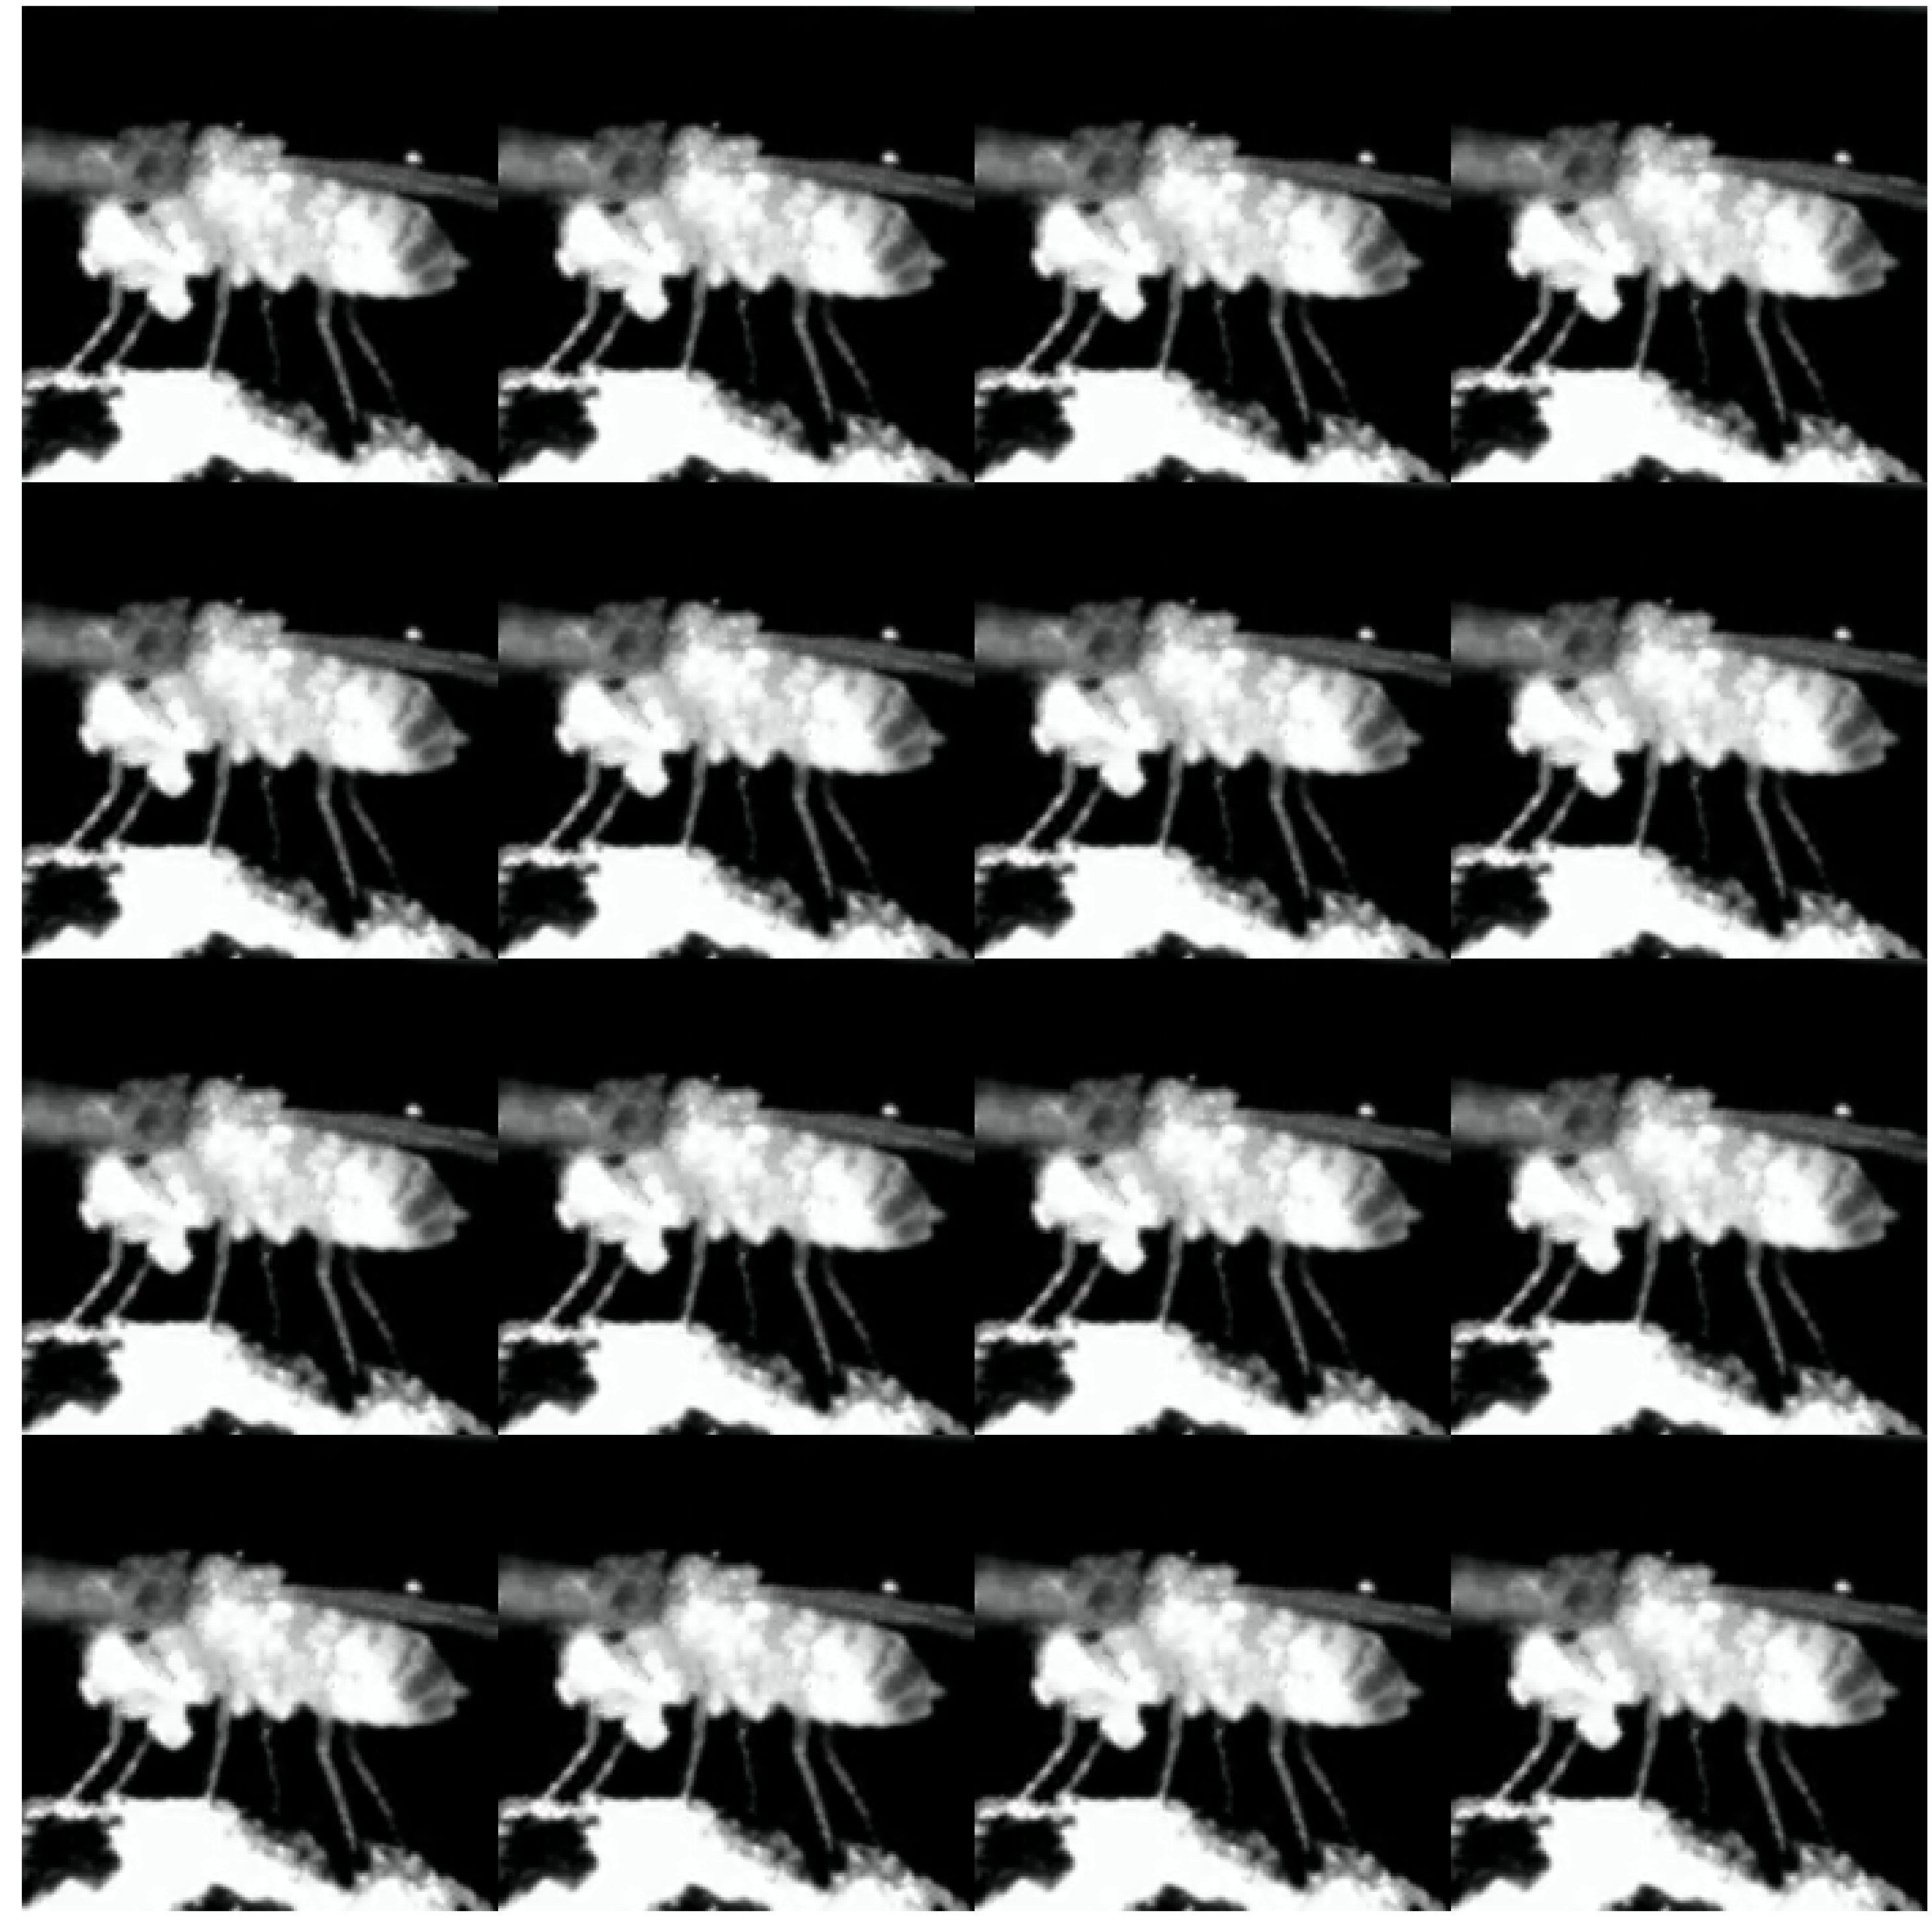

In [118]:
fig = plt.figure(figsize=(10,10))
NUM_AXES = 10
CLUSTER_NUM = 10
PRE_MS = 1000
POST_MS = 1000
STEP_MS = 50


num_frames = int((POST_MS+PRE_MS)/STEP_MS)

width = int(np.ceil(np.sqrt(NUM_AXES)))
axes = []
for i in range(width**2): # must be 0 index
    x = i%width
    y = int(np.ceil((i+1)/width))
    axes.append(fig.add_axes([x, y, 1, 1]))
    axes[-1].imshow(frames[100][35:210,325:500,:])
    axes[-1].axis('off')
    
def animate(i):
    
    brain_idx = np.where(cluster_vector==CLUSTER_NUM)[0]
    for k,j in enumerate(brain_idx):
        if k<= NUM_AXES:
            time = timestamps[:,20][j]
            time = time - PRE_MS + STEP_MS*i
            behavior_idx = np.searchsorted(xnew, time)
            axes[k].set_array(frames[behavior_idx][35:210,325:500,:])

    return tuple(im)

anim = animation.FuncAnimation(fig, animate, frames=num_frames, interval=STEP_MS, blit=True)
HTML(anim.to_html5_video())
rc('animation', html='html5')
anim

In [117]:
CLUSTER_NUM=10
brain_idx = np.where(cluster_vector==CLUSTER_NUM)[0]
for k,j in enumerate(brain_idx):
    if k<= NUM_AXES:
        time = timestamps[:,20][j]
        time = time - PRE_MS + STEP_MS*i
        behavior_idx = np.searchsorted(xnew, time)
        im.set_array(frames[behavior_idx][35:210,325:500,:])

j: 958
time: 384557.53778
behavior_idx: 19228
j: 969
time: 388970.48346
behavior_idx: 19449
j: 991
time: 397796.37481999997
behavior_idx: 19890
j: 1009
time: 405017.55866000004
behavior_idx: 20251
j: 1471
time: 590361.27722
behavior_idx: 29519
j: 1539
time: 617641.30506
behavior_idx: 30883
j: 1548
time: 621251.89698
behavior_idx: 31063
j: 1579
time: 633688.38026
behavior_idx: 31685
j: 1607
time: 644921.3329
behavior_idx: 32247
j: 1740
time: 698277.85794
behavior_idx: 34914
j: 1805
time: 724354.35514
behavior_idx: 36218


In [111]:
timestamps[:,20]

array([2.30086740e+02, 6.31263620e+02, 1.03244050e+03, ...,
       1.82598607e+06, 1.82638724e+06, 1.82678842e+06])

In [105]:
np.where(cluster_vector==10)[0]

array([ 958,  969,  991, 1009, 1471, 1539, 1548, 1579, 1607, 1740, 1805,
       1818, 1965, 2303, 2506])

In [121]:
import numpy as np
import time
import os
import sys
import scipy
import math
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
import pandas as pd
import psutil
import json
from tqdm import tqdm
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import bigbadbrain as bbb
from scipy.linalg import toeplitz
import scipy.linalg as sl
from scipy.signal import convolve2d
from scipy.signal import convolve
import sklearn
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn import linear_model

#from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
#import cv2
import os
import statsmodels.api as sm

from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
from IPython.display import HTML

%matplotlib inline

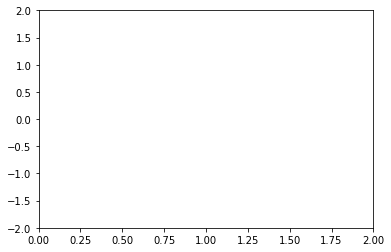

In [123]:
fig, ax = plt.subplots()

ax.set_xlim(( 0, 2)), ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)
def init():
    line.set_data([], [])
    return (line,)
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return (line,)
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)
#HTML(anim.to_html5_video())
#rc('animation', html='html5')
#anim

In [132]:
anim.save('20191220_test.mp4',dpi=200,extra_args=['-vcodec', 'libx264'])

MovieWriter ffmpeg unavailable. Trying to use pillow instead.


ValueError: unknown file extension: .mp4

In [125]:
HTML(anim.to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available

# FUCK THIS FFMPEG ERROR FUCK YOU FUCK YOU FUCK YOU

# AND FUCK YOU

# lets just save FUCKING jpegs

In [136]:
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20191220_0'
os.mkdir(save_path)

In [236]:
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20191220_cluster_videos'
os.mkdir(save_path)

In [245]:
for i in range(1,3):
    print(i)

1
2


In [ ]:
for CLUSTER_NUM in range(2,28):
    print('CLUSTER {}'.format(CLUSTER_NUM))
    fig = plt.figure(figsize=(10,10))
    save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20191220_cluster_videos/cluster_{}'.format(CLUSTER_NUM)
    os.mkdir(save_path)
    NUM_AXES = 144
    #CLUSTER_NUM = 1
    PRE_MS = 1000
    POST_MS = 1000
    STEP_MS = 50
    IMAGING_RATE = 400 # in ms for bruker

    IMAGING_RATE = IMAGING_RATE/2
    num_frames = int((POST_MS+PRE_MS)/STEP_MS)
    width = int(np.ceil(np.sqrt(NUM_AXES)))
    axes = []
    images = []
    for i in range(width**2): # must be 0 index
        x = i%width
        y = int(np.ceil((i+1)/width))
        ax = fig.add_axes([x, y, 1, 1])
        #im = ax.imshow(frames[100][35:210,325:500,:])
        im = ax.imshow([[0,0],[0,0]])
        ax.axis('off')
        images.append(im)
        axes.append(ax)

    for i in range(num_frames):
        print('Frame {} of {}'.format(i, num_frames))
        brain_idx = np.where(cluster_vector==CLUSTER_NUM)[0]
        for k,j in enumerate(brain_idx):
            if k< NUM_AXES:
                trigger_time = timestamps[:,20][j]
                time = trigger_time - PRE_MS + STEP_MS*i
                behavior_idx = np.searchsorted(xnew, time)
                try:
                    images[k].set_array(frames[behavior_idx][35:210,325:500,:])
                except: #for catching behavior_idx that are outside of imaging
                    print('error')
                    images[k].set_array([[0,0],[0,0]])
                if trigger_time-IMAGING_RATE < time < trigger_time+IMAGING_RATE:
                    circle = plt.Circle((-0.15, -0.15), .2, color='r')
                else:
                    circle = plt.Circle((-0.15, -0.15), .2, color='k')
                axes[k].add_artist(circle)
        fname = os.path.join(save_path, '{0:05d}.png'.format(i))
        plt.savefig(fname,dpi=10,bbox_inches='tight')

CLUSTER 2
Frame 0 of 40
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
Frame 1 of 40
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
Frame 2 of 40
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
Frame 3 of 40
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
Frame 4 of 40
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
Frame 5 of 40
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
Frame 6 of 40
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
Frame 7 of

Frame 36 of 40
error
error
error
error
error
Frame 37 of 40
error
error
error
error
error
Frame 38 of 40
error
error
error
error
error
Frame 39 of 40
error
error
error
error
error
CLUSTER 5
Frame 0 of 40
Frame 1 of 40
Frame 2 of 40
Frame 3 of 40
Frame 4 of 40
Frame 5 of 40
Frame 6 of 40
Frame 7 of 40
Frame 8 of 40
Frame 9 of 40
Frame 10 of 40
Frame 11 of 40
Frame 12 of 40
Frame 13 of 40
Frame 14 of 40
Frame 15 of 40
Frame 16 of 40
Frame 17 of 40
Frame 18 of 40
Frame 19 of 40
Frame 20 of 40
Frame 21 of 40
Frame 22 of 40
Frame 23 of 40
Frame 24 of 40
Frame 25 of 40
Frame 26 of 40
Frame 27 of 40
Frame 28 of 40
Frame 29 of 40
Frame 30 of 40
Frame 31 of 40
Frame 32 of 40
Frame 33 of 40
Frame 34 of 40
Frame 35 of 40
Frame 36 of 40
Frame 37 of 40
Frame 38 of 40
Frame 39 of 40
CLUSTER 6
Frame 0 of 40
Frame 1 of 40
Frame 2 of 40
Frame 3 of 40
Frame 4 of 40
Frame 5 of 40
Frame 6 of 40
Frame 7 of 40
Frame 8 of 40
Frame 9 of 40
Frame 10 of 40
Frame 11 of 40
Frame 12 of 40
Frame 13 of 40
Frame 14 o

Frame 27 of 40
error
error
error
error
error
error
error
error
Frame 28 of 40
error
error
error
error
error
error
error
error
Frame 29 of 40
error
error
error
error
error
error
error
error
Frame 30 of 40
error
error
error
error
error
error
error
error
Frame 31 of 40
error
error
error
error
error
error
error
error
Frame 32 of 40
error
error
error
error
error
error
error
error
Frame 33 of 40
error
error
error
error
error
error
error
error
Frame 34 of 40
error
error
error
error
error
error
error
error
Frame 35 of 40
error
error
error
error
error
error
error
error
Frame 36 of 40
error
error
error
error
error
error
error
error
Frame 37 of 40
error
error
error
error
error
error
error
error
Frame 38 of 40
error
error
error
error
error
error
error
error
Frame 39 of 40
error
error
error
error
error
error
error
error
CLUSTER 10
Frame 0 of 40
Frame 1 of 40
Frame 2 of 40
Frame 3 of 40
Frame 4 of 40
Frame 5 of 40
Frame 6 of 40
Frame 7 of 40
Frame 8 of 40
Frame 9 of 40
Frame 10 of 40
Frame 11 of 40


In [242]:
for k,j in enumerate(np.where(cluster_vector==2)[0]):
    print(k,j)

0 1746
1 1869
2 2046
3 2064
4 2141
5 2147
6 2192
7 2235
8 2266
9 2288
10 2326
11 2461
12 2507
13 2908
14 2950
15 2961
16 2980
17 3004
18 3074
19 3079
20 3086
21 3184
22 3231
23 3237
24 3249
25 3254
26 3280
27 3293
28 3318
29 3331
30 3345
31 3353
32 3360
33 3372
34 3376
35 3395
36 3403
37 3412
38 3419
39 3423
40 3427
41 3432
42 3435
43 3440
44 3473
45 3478
46 3483
47 3489
48 3492
49 3508
50 3516
51 3518
52 3520
53 3540
54 3550
55 3557
56 3561
57 3564
58 3573
59 3584
60 3586
61 3599
62 3610
63 3615
64 3619
65 3626
66 3671
67 3672
68 3683
69 3699
70 3718
71 3734
72 3745
73 3756
74 3757
75 3761
76 3762
77 3763
78 3766
79 3785
80 3787
81 3791
82 3792
83 3796
84 3803
85 3809
86 3811
87 3812
88 3817
89 3825
90 3833
91 3837
92 3838
93 3841
94 3845
95 3850
96 3851
97 3852
98 3877
99 3882
100 3890
101 3900
102 3912
103 3954
104 3985
105 3988
106 3991
107 4049
108 4097
109 4099
110 4148
111 4191
112 4216
113 4281
114 4307
115 4311
116 4351
117 4388
118 4400
119 4401
120 4424
121 4449
122 4461
123

In [244]:
images[2]

In [231]:
len(np.where(cluster_vector==1)[0])

21

In [235]:
max(cluster_vector)

27

(-50, 50)

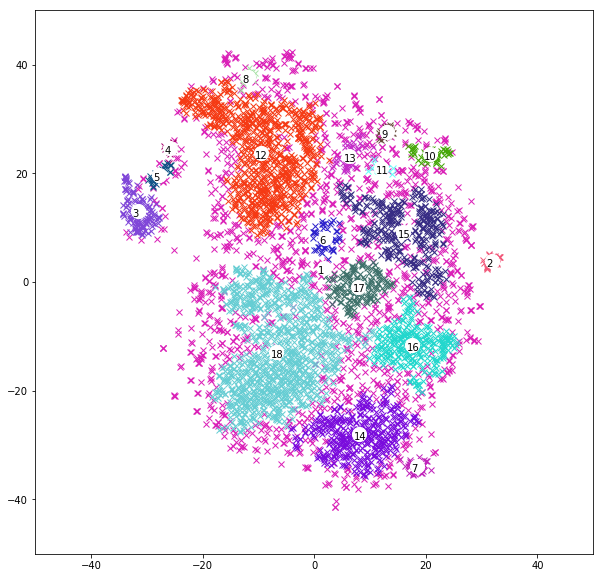

In [217]:
plt.figure(figsize=(10,10))
for i in clusters_array:
    plt.plot(clusters_array[i][:,0],clusters_array[i][:,1],linestyle='',marker='x',color=colors[i],zorder=0)
    plt.scatter(cluster_means[i][0],cluster_means[i][1],color='white',s=200,zorder=1)
    plt.text(cluster_means[i][0]-1,cluster_means[i][1]-1,str(i+1))
plt.xlim(-50,50)
plt.ylim(-50,50)

In [211]:
behavior_idx

72599

In [212]:
np.diff(timestamps[:,20])

array([401.17688, 401.17688, 401.17688, ..., 401.17688, 401.17688,
       401.17688])